In [29]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np

In [30]:
with open('data/logs_exracted.json') as f:
    a = json.load(f)

In [31]:
df_logs = pd.DataFrame.from_dict({(i,j): a[i][j] 
                           for i in a.keys() 
                           for j in a[i].keys()},orient='index').reset_index()

df_logs= df_logs.fillna(0)
two_groups = '(?P<competition>[a-zA-Z\-]+)(?P<year>[0-9]+)'

df_logs = pd.concat([df_logs,df_logs['level_0'].str.extract(two_groups)],axis=1)
df_logs['year'] = df_logs['year'].astype('int64')
df_logs = df_logs.drop(['level_0'],axis=1)
df_logs['win_diff'] = df_logs.apply(lambda x: (x['win']-x['loss'])/x['games'],axis=1)
df_logs['win_rate'] = df_logs.apply(lambda x: (x['win'])/x['games'],axis=1)
df_logs['goals_diff'] = df_logs.apply(lambda x: float(x['S']-x['R'])/x['games'],axis=1)
df_logs['loss_rate'] = df_logs.apply(lambda x: (x['loss'])/x['games'],axis=1)
df_logs= df_logs.sort_values('win_diff')
df_logs =df_logs.rename({'level_1':'teamname'},axis='columns')

df_logs.head()

,teamname,loss,S,R,games,tie,win,competition,year,win_diff,win_rate,goals_diff,loss_rate
996,-humboldt,4.0,0,13,4,0.0,0.0,WorldCup,2005,-1.0,0.0,-3.250000,1.0
928,chagamma,5.0,1,25,5,0.0,0.0,WorldCup,2003,-1.0,0.0,-4.800000,1.0
500,og,4.0,1,11,4,0.0,0.0,JapanAutumnCamp,2010,-1.0,0.0,-2.500000,1.0
808,_utaustinvilla,1.0,0,6,1,0.0,0.0,USOpens,2004,-1.0,0.0,-6.000000,1.0
99,ahua,3.0,1,11,3,0.0,0.0,ChinaOpens,2007,-1.0,0.0,-3.333333,1.0


In [32]:
df_logs[df_logs['year']==2005].head()

,teamname,loss,S,R,games,tie,win,competition,year,win_diff,win_rate,goals_diff,loss_rate
996,-humboldt,4.0,0,13,4,0.0,0.0,WorldCup,2005,-1.0,0.0,-3.25,1.0
811,borregos,10.0,1,39,10,0.0,0.0,USOpens,2005,-1.0,0.0,-3.80,1.0
768,anct2005,10.0,0,34,10,0.0,0.0,SpringCompetitions,2005,-1.0,0.0,-3.40,1.0
440,-one,1.0,0,4,1,0.0,0.0,JapanAutumnCamp,2005,-1.0,0.0,-4.00,1.0
441,_grana05,3.0,0,6,3,0.0,0.0,JapanAutumnCamp,2005,-1.0,0.0,-2.00,1.0


In [33]:
df_logs['team'] = [x.strip('_-').lower() for x in df_logs['teamname']]


In [34]:
df_results = pd.read_csv('data/competition_results.csv')

df_results.head()

,avg_goal_diff,avg_goals_scored,country,dir,drawn,goals_received,goals_scored,lost,matches,points,score,team,teamname,won,year,competition
0,2.000000,3.000000,brazil,/home/itandroids,0,1,3,0,1,3,NaN,NaN,ITAndroids,1,2013,CBR
1,-2.000000,1.000000,brazil,/home/uaisoccer2d,0,3,1,1,1,0,NaN,NaN,UAISoccer2D,0,2013,CBR
2,2.000000,2.000000,brazil,/home/itandroids,0,0,6,0,3,9,NaN,NaN,ITAndroids,3,2013,CBR
3,0.333333,2.333333,brazil,/home/warthog2d,1,6,7,1,3,4,NaN,NaN,Warthog,1,2013,CBR
4,-0.666667,1.333333,brazil,/home/furgbot,2,6,4,1,3,2,NaN,NaN,Furgbot,0,2013,CBR


In [35]:
df_results_sum = df_results.groupby(['competition','year','teamname']).sum().reset_index()

In [36]:
df1 = df_logs.merge(df_results_sum,how='inner',on=['competition','year','teamname'])[['competition','year','teamname','games','matches']]


In [37]:
diffs = df1[['games','matches']].apply(lambda x: x[0]-x[1],axis=1)

In [38]:
diffs.describe()

count    5.00000
mean    -0.80000
std      0.83666
min     -2.00000
25%     -1.00000
50%     -1.00000
75%      0.00000
max      0.00000
dtype: float64

In [39]:
df1[['games','matches']].corr()

,games,matches
games,1.000000,0.999716
matches,0.999716,1.000000


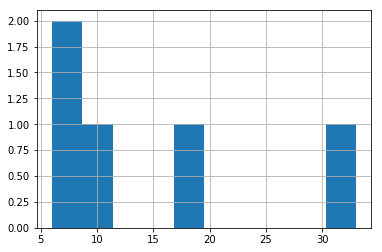

In [40]:
df1['games'].hist() 

## Data validation : 

### correlation between goals scores and and wins 

In [41]:
df_logs[['win','S']].corr()

,win,S
win,1.000000,0.941496
S,0.941496,1.000000


### correlation between goals recived and losses 

In [42]:
df_logs[['loss','R']].corr()

,loss,R
loss,1.000000,0.917302
R,0.917302,1.000000


In [43]:
df_logs[df_logs['games']==0]

,teamname,loss,S,R,games,tie,win,competition,year,win_diff,win_rate,goals_diff,loss_rate,team


In [44]:
df_ranks_raw = pd.read_csv('data/ranks_wiki.csv')

In [45]:
df_ranks_raw.shape[0]

20

In [46]:
results = [] 
for _,r in df_ranks_raw.iterrows(): 
    results +=  [(r.Year,r[c].lower(),4-int(c[0])) for c in df_ranks_raw.columns[1:]]

In [47]:
df_ranks = pd.DataFrame(results,columns=['year','team','rank'])

In [48]:
df_ranks_logs1= df_ranks.merge(df_logs[df_logs['competition']=='WorldCup'][['year','team']],on=['year'],
                               how='inner')

In [49]:
matched_df = df_ranks_logs1[df_ranks_logs1.apply(lambda x: (x['team_x'] in x['team_y']) or (x['team_y'] in x['team_x']),axis=1) ]
matched_df = matched_df.drop('team_x',axis=1)
matched_df= matched_df.rename({'team_y':'team'},axis=1)
matched_df['competition'] =  'WorldCup'
matched_df[matched_df['year']==2005]


,year,rank,team,competition
794,2005,3,t,WorldCup
807,2005,3,brainstormers05,WorldCup
825,2005,2,we2005,WorldCup
828,2005,1,t,WorldCup
839,2005,1,tokyotech2005,WorldCup


In [50]:
df_ranks_logs1 = None

In [51]:
df_ranks_logs = df_logs.merge(matched_df, on = ['competition','year','team'],how='left')
df_ranks_logs.shape[0]

1294

In [52]:
df_ranks_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 0 to 1293
Data columns (total 15 columns):
teamname       1294 non-null object
loss           1294 non-null float64
S              1294 non-null int64
R              1294 non-null int64
games          1294 non-null int64
tie            1294 non-null float64
win            1294 non-null float64
competition    1294 non-null object
year           1294 non-null int64
win_diff       1294 non-null float64
win_rate       1294 non-null float64
goals_diff     1294 non-null float64
loss_rate      1294 non-null float64
team           1294 non-null object
rank           53 non-null float64
dtypes: float64(8), int64(4), object(3)
memory usage: 161.8+ KB


In [53]:
df_ranks_logs.to_csv('checkpoints/logs-ranks.csv')

In [54]:
import seaborn as sns

Text(0.5,1,'Total Goals Scored Vs rank')

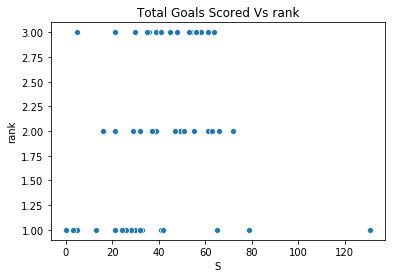

In [55]:
sns.scatterplot(data=df_ranks_logs,x='S',y='rank').set_title('Total Goals Scored Vs rank')


Text(0.5,1,'Wins-Losses / Games  vs Rank')

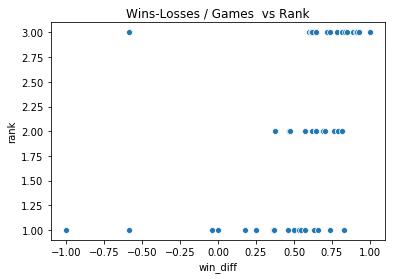

In [56]:
sns.scatterplot(data=df_ranks_logs,x='win_diff',y='rank').set_title('Wins-Losses / Games  vs Rank')

Text(0.5,1,'wins / games vs rank')

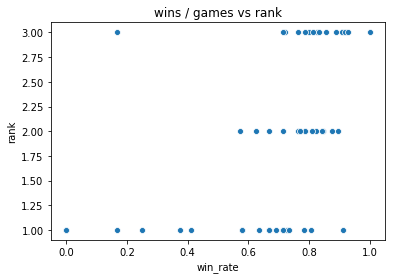

In [57]:
sns.scatterplot(data=df_ranks_logs,x='win_rate',y='rank').set_title('wins / games vs rank')

Text(0.5,1,'goals diff vs rank')

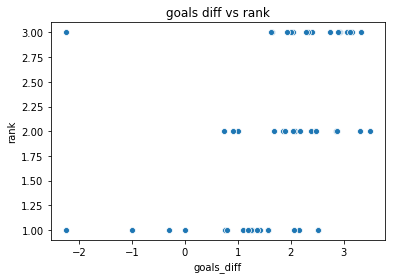

In [58]:
sns.scatterplot(data=df_ranks_logs,x='goals_diff',y='rank').set_title('goals diff vs rank')

Text(0.5,1,'loss rate vs rank')

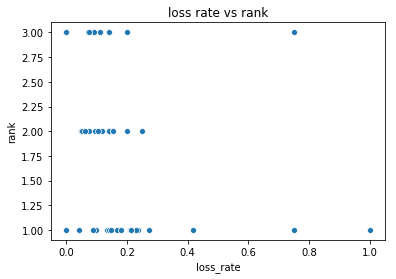

In [59]:
sns.scatterplot(data=df_ranks_logs,x='loss_rate',y='rank').set_title('loss rate vs rank')

In [60]:
df_ranks_logs[~df_ranks_logs['rank'].isnull()].corr()

,loss,S,R,games,tie,win,year,win_diff,win_rate,goals_diff,loss_rate,rank
loss,1.000000,-0.064028,0.877924,0.314138,0.199389,-0.067849,0.176371,-0.593785,-0.457567,-0.641969,0.650477,-0.358770
S,-0.064028,1.000000,0.176213,0.824917,0.147093,0.924938,0.396967,0.570110,0.599754,0.657964,-0.431728,0.167100
R,0.877924,0.176213,1.000000,0.452705,0.319601,0.102310,0.279346,-0.410591,-0.303141,-0.465739,0.465726,-0.215192
games,0.314138,0.824917,0.452705,1.000000,0.463149,0.896705,0.468290,0.329564,0.365219,0.260298,-0.227312,-0.045433
tie,0.199389,0.147093,0.319601,0.463149,1.000000,0.177099,0.270406,-0.068448,-0.218437,-0.159881,-0.124151,-0.214354
win,-0.067849,0.924938,0.102310,0.896705,0.177099,1.000000,0.394188,0.615778,0.647597,0.579963,-0.466551,0.140837
year,0.176371,0.396967,0.279346,0.468290,0.270406,0.394188,1.000000,0.204536,0.223009,0.172165,-0.145469,0.087085
win_diff,-0.593785,0.570110,-0.410591,0.329564,-0.068448,0.615778,0.204536,1.000000,0.932503,0.899205,-0.900884,0.437247
win_rate,-0.457567,0.599754,-0.303141,0.365219,-0.218437,0.647597,0.223009,0.932503,1.000000,0.869664,-0.683312,0.474523
goals_diff,-0.641969,0.657964,-0.465739,0.260298,-0.159881,0.579963,0.172165,0.899205,0.869664,1.000000,-0.772639,0.427713


In [61]:
df_ranks_logs['is_ranked'] = ~df_ranks_logs['rank'].isnull()
df_ranks_logs.drop('rank',inplace=True,axis=1)

In [62]:
agg = df_ranks_logs[df_ranks_logs['competition']=='WorldCup'].groupby(['year','is_ranked']).mean().reset_index()

In [63]:
agg1 = agg.melt(id_vars=['year','is_ranked'],value_vars=agg.columns[2:])

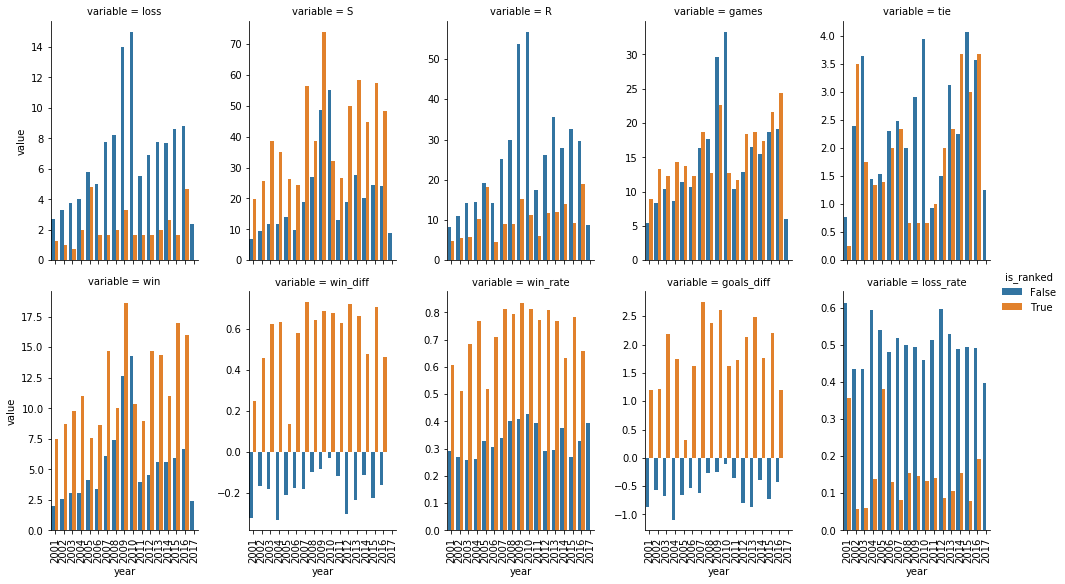

In [64]:
g = sns.catplot(x="year", y="value",
                hue="is_ranked", col="variable",
                data=agg1, kind="bar",
                height=4, aspect=.7,col_wrap=5,sharey=False);
g.set_xticklabels(rotation=90)

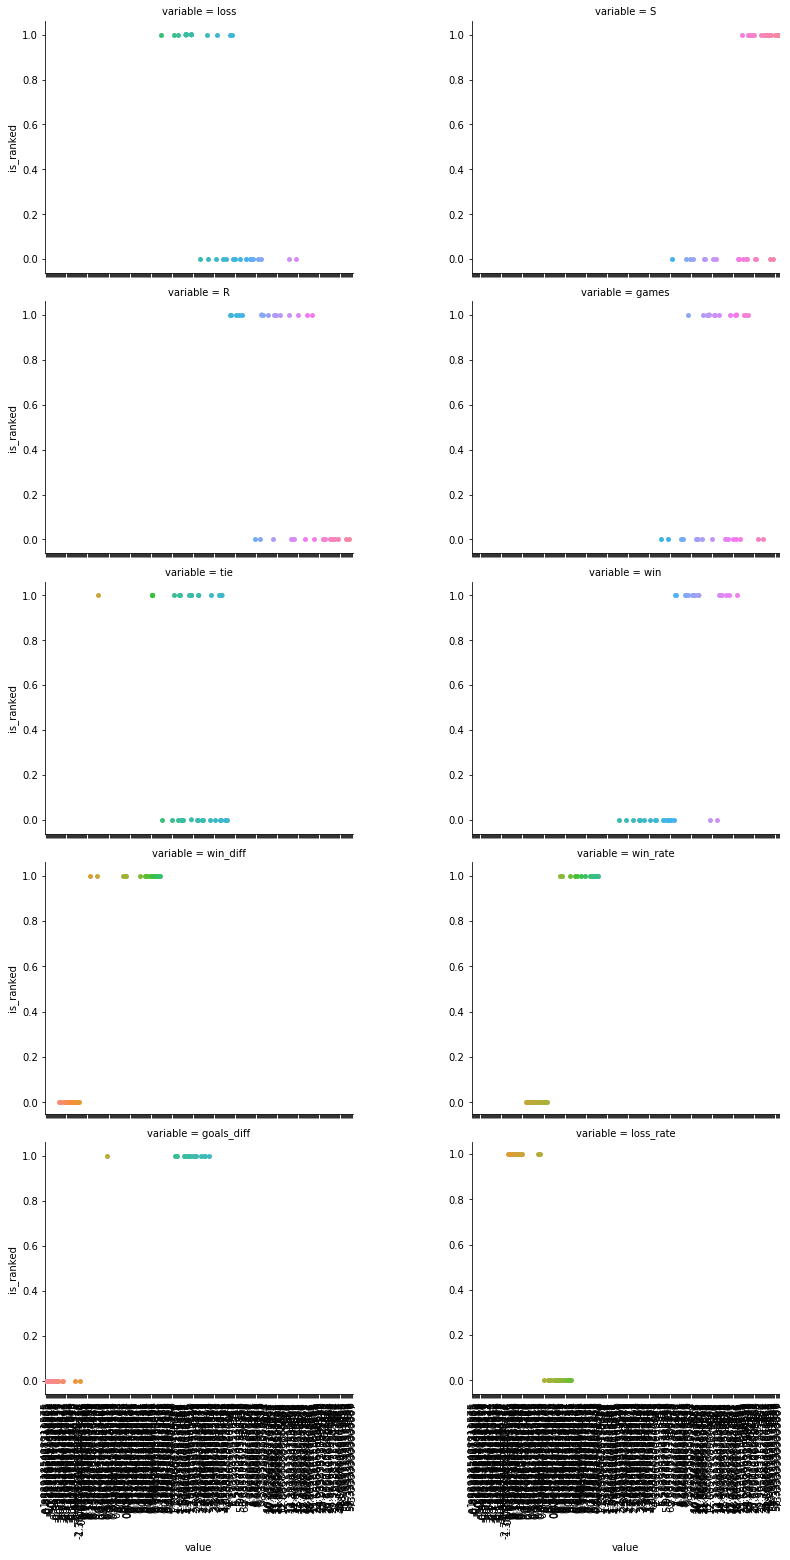

In [71]:
g = sns.catplot(x="value", y="is_ranked",
                 col="variable",
                data=agg1, 
                height=4,aspect=1.5,  col_wrap=2,sharey=False);
g.set_xticklabels(rotation=90)